### TRABALHO FINAL Deep Learnig I

##### Auno: Leandro Rossetti

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

#### Verifica se existe uma GPU na maquina, e caso exista utilizara a mesma para o processamento

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Copia o dataset de imagens para ser utiizado no treinamento e validação

In [3]:
!git clone https://github.com/leandroro7/imagens.git

fatal: destination path 'imagens' already exists and is not an empty directory.


#### Na celula abaixo são feitas as transformações e criados os dataloaders que serão utilizados ao longo do código 

In [4]:
# Aplica algumas mudanças as imagens para tentar diminuir o overfiting
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Aplica apenas o redimensionamento da imagem
transform_validation = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Carregas as imagens aplicando as transformações definidas anteriormente    
training_dataset = datasets.ImageFolder('imagens/treino', transform=transform_train)
validation_dataset = datasets.ImageFolder('imagens/validacao', transform=transform_validation)

# configura um DataLoader para pegar aleatoriamente 20 imagens de cada batch,a quantidade de 20 
# foi definida por ser esse um dataset pequeno, justificando assim um valor baixo para esse parametro
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=True)

#### Na celula abaixo podem ser  feitas algumas verificaões visuias do resultado das operações executadas anteriormente

In [5]:
print(len(training_dataset))
print(len(validation_dataset))
!find imagens/ -type f | wc -l  

244
153


'wc' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


#### A função im_convert apenas trata o tensor recebido para que o mesmo possa ser plotado como uma imagem.

In [6]:
# Transforma novamente o tensor recebido para uma imagem que pode ser exibida
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

#### Ploto um Batch de 20 imagens e suas classes originais

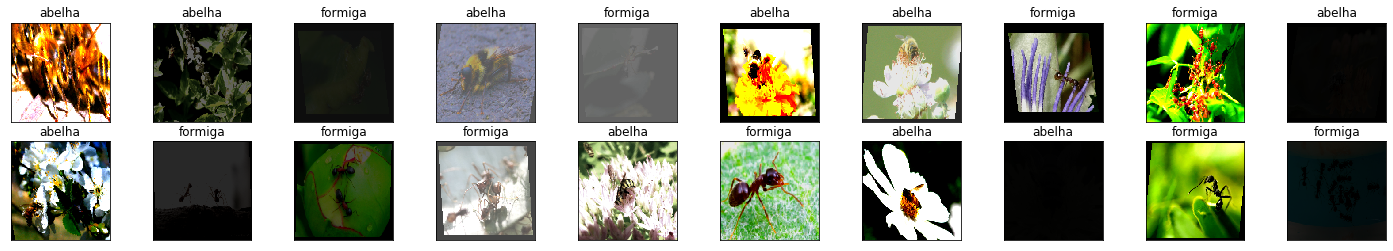

In [7]:
classes = ('abelha', 'formiga')

def ShowBatchImages(loader):
    # Define os labels para as imagens plotadas
    
    # Cria um iterador sobre o batch de 20 imagens
    dataiter = iter(loader)

    # images = Tensor com os dados das imagens
    # labels = Tensor com o indice dos labels
    images, labels = dataiter.next()

    # cria a figura que recebera os dados da imagem
    fig = plt.figure(figsize=(25, 4))

    # Itera pelo batch de 20 imagens gerando um plot de cada uma, com a respectiva classe
    for idx in np.arange(20):
      ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
      plt.imshow(im_convert(images[idx]))
      ax.set_title(classes[labels[idx].item()])
    

ShowBatchImages(training_loader)

 #### Na celula abaixo são definidos os modelos que serão utilizados no decorrer do código

In [8]:
# Cria mo modelo AlexNet
modelAlexNet = models.alexnet(pretrained=True)

# Cria mo modelo VGG16
modelVgg = models.vgg16(pretrained=True)


#### Print do modelo VGG criado

In [9]:
print(modelVgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Print do modelo AlexNet criado

In [10]:
print(modelAlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Como estou utilizando um modelo pré-treinado, na celula abaixo utilizo um loop para "congelar" a parte de extração de features do modelo para não perder o "conhecimento" ja acumulado.

In [11]:
for param in modelVgg.features.parameters():
  param.requires_grad = False

for param in modelAlexNet.features.parameters():
  param.requires_grad = False


#### Na celula abaixo é feito o ajuste da camada de saida, pois agora existem apenas duas classes para serem classificadas

In [12]:
import torch.nn as nn

#Reduz o numero de classes de saida de 1000 para 2 no modelo VGG
n_inputs = modelVgg.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
modelVgg.classifier[6] = last_layer
modelVgg.to(device)
print(modelVgg.classifier)

#Reduz o numero de classes de saida de 1000 para 2 no modelo AlexNet
n_inputs = modelAlexNet.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
modelAlexNet.classifier[6] = last_layer
modelAlexNet.to(device)
print(modelAlexNet.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


#### Foram definidos para teste nesse trabalho duas funções de custo [CrossEntropy, NLLLoss] e dois otimizadores [Adam, SGD], definidos abaixo:

In [13]:
# Definição extraida da documentação disponível em: https://pytorch.org/docs/stable/nn.html#
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It is useful when training a classification problem with C classes. 
criterionCrossEntropy = nn.CrossEntropyLoss()

# Definição extraida da documentação disponível em: https://pytorch.org/docs/stable/nn.html#
# The negative log likelihood loss. It is useful to train a classification problem with C classes.
criterionNLLL = nn.NLLLoss()

# Definição extraida da documentação disponível em: https://pytorch.org/docs/stable/optim.html#
# Implements Adam algorithm. 
optimizerAdamVgg = torch.optim.Adam(modelVgg.parameters(), lr = 0.0001)
optimizerAdamAlexNet = torch.optim.Adam(modelAlexNet.parameters(), lr = 0.0001)

# Definição extraida da documentação disponível em: https://pytorch.org/docs/stable/optim.html#
# O optimizer SGD Implements stochastic gradient descent (optionally with momentum)
optimizerSGDVgg = torch.optim.SGD(modelVgg.parameters(), lr = 0.0001)
optimizerSGDAlexNet = torch.optim.SGD(modelAlexNet.parameters(), lr = 0.0001)


#### FUNÇÃO DE TREINAMENTO
##### Essa função é chamada para cada um dos dos conjuntos de teste definidos mais adiante

In [14]:
# VARIAVEIS QUE SERÃO UTILIZADAS NA FUNÇÃO E AO LONGO DO CÓDIGO

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

#FUNÇÃO DE TREINAMENTO
# optimizer = Função deativação
# criterion = Função de Custo 
# model = Modelo PRE-TREINADO
# epochs = Quantidade de epocas do treino
def Treinamento(optimizer, criterion, model, epochs):
   
    # PARA CADA EPOCA
    for e in range(epochs):

      running_loss = 0.0
      running_corrects = 0.0
      val_running_loss = 0.0
      val_running_corrects = 0.0

      for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Definir os gradientes para zero, quando você inicia seu ciclo de treinamento, 
        # zerar os gradientes garente que você atualize o parâmetro corretamente. 
        optimizer.zero_grad()
        
        # Chamar .backward() acumula o gradiente (por adição) para cada parâmetro. 
        # Deve-se chamar optimizer.zero_grad () após cada chamada .step(). 
        # Observe que, após a primeira chamada .backward, uma segunda chamada só é possível após a execução de outra passagem.
        loss.backward()
        
        # executa uma atualização de parâmetro com base no gradiente atual (armazenado no atributo .grad de 
        # um parâmetro) Como exemplo, a regra de atualização para o SGD é definida aqui:
        # https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

      else:
        # O wrapper "with torch.no_grad ()" seta temporariamente require_grad como false. 
        # Um exemplo do tutorial oficial do PyTorch:
        # (https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#gradients)
        with torch.no_grad():
          for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss/len(training_loader.dataset)
        epoch_acc = running_corrects.float()/ len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        print()
        ShowBatchImages(training_loader)        
        

### Conjunto de testes 

#### O conjunto de testes sera composto por dois modelos e quatro duplas de Otimizadores e Funções de custo detalhadas a seguir:

##### Para o modelo VGG16

1. Função de custo CrossEntropy e Otimizador Adam
2. Função de custo CrossEntropy e Otimizador SGD
3. Função de custo NLLL e Otimizador Adam
4. Função de custo NLLL e Otimizador SGD


##### Para o modelo AlexNet

1. Função de custo CrossEntropy e Otimizador Adam
2. Função de custo CrossEntropy e Otimizador SGD
3. Função de custo NLLL e Otimizador Adam
4. Função de custo NLLL e Otimizador SGD


#### Ao todo serão executados oito rodadas de testes cobrindo todos os modelos e hyperparametros definidos acima


####  Para testar o modelo VGG16 com Função de custo CrossEntropy e Otimizador Adam execute a celula abaixo

In [15]:
# Para o modelo VGG16
# Função de custo CrossEntropy e Otimizador Adam
criterion = criterionCrossEntropy
optimizer = optimizerAdamVgg
epochs = 5

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelVgg, epochs)

epoch : 1
training loss: 0.0276, acc 0.7459 
validation loss: 0.0144, validation acc 0.8889 
epoch : 2
training loss: 0.0240, acc 0.7828 
validation loss: 0.0130, validation acc 0.9412 
epoch : 3
training loss: 0.0155, acc 0.8484 
validation loss: 0.0158, validation acc 0.8889 
epoch : 4
training loss: 0.0111, acc 0.8975 
validation loss: 0.0188, validation acc 0.8954 
epoch : 5
training loss: 0.0137, acc 0.8934 
validation loss: 0.0192, validation acc 0.9020 


####  Para testar o modelo VGG16 com Função de custo CrossEntropy e Otimizador SGD execute a celula abaixo

In [23]:
# Para o modelo VGG16
# Função de custo CrossEntropy e Otimizador SGD
criterion = criterionCrossEntropy
optimizer = optimizerSGDVgg
epochs = 5

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelVgg, epochs)

epoch : 1
training loss: 0.0090, acc 0.9139 
validation loss: 0.0187, validation acc 0.9085 
epoch : 2
training loss: 0.0105, acc 0.9016 
validation loss: 0.0163, validation acc 0.9216 
epoch : 3
training loss: 0.0088, acc 0.9221 
validation loss: 0.0180, validation acc 0.9150 
epoch : 4
training loss: 0.0127, acc 0.8648 
validation loss: 0.0176, validation acc 0.9346 
epoch : 5
training loss: 0.0148, acc 0.8607 
validation loss: 0.0169, validation acc 0.9346 


####  Para testar o modelo VGG16 com Função de custo NLLL e Otimizador Adam execute a celula abaixo

In [35]:
# Para o modelo VGG16
# Função de custo NLLL e Otimizador Adam
criterion = criterionNLLL
optimizer = optimizerAdamVgg
epochs = 5

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelVgg, epochs)

epoch : 1
training loss: -1842.8679, acc 0.5287 
validation loss: -3526.9435, validation acc 0.5359 
epoch : 2
training loss: -3860.7961, acc 0.5000 
validation loss: -6183.1170, validation acc 0.4902 
epoch : 3
training loss: -5764.7626, acc 0.4590 
validation loss: -10002.5918, validation acc 0.5163 
epoch : 4
training loss: -9613.8258, acc 0.5246 
validation loss: -14987.2163, validation acc 0.5490 
epoch : 5
training loss: -14125.3810, acc 0.5246 
validation loss: -21699.9745, validation acc 0.5229 
epoch : 6
training loss: -20755.7979, acc 0.5533 
validation loss: -30108.0678, validation acc 0.5163 
epoch : 7
training loss: -27831.5993, acc 0.5082 
validation loss: -40438.0351, validation acc 0.5294 
epoch : 8
training loss: -34220.4338, acc 0.5410 
validation loss: -52556.5114, validation acc 0.4641 
epoch : 9
training loss: -49591.5740, acc 0.5123 
validation loss: -66797.8897, validation acc 0.5163 
epoch : 10
training loss: -58493.7041, acc 0.5164 
validation loss: -83572.0678

####  Para testar o modelo VGG16 com Função de custo NLLL e Otimizador SGD execute a celula abaixo

In [42]:
# Para o modelo VGG16
# Função de custo NLLL e Otimizador SGD
criterion = criterionNLLL
optimizer = optimizerSGDVgg
epochs = 5

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelVgg, epochs)

epoch : 1
training loss: nan, acc 0.4754 
validation loss: nan, validation acc 0.5425 
epoch : 2
training loss: nan, acc 0.4959 
validation loss: nan, validation acc 0.5425 
epoch : 3
training loss: nan, acc 0.4959 
validation loss: nan, validation acc 0.5425 
epoch : 4
training loss: nan, acc 0.4959 
validation loss: nan, validation acc 0.5425 
epoch : 5
training loss: nan, acc 0.4959 
validation loss: nan, validation acc 0.5425 


####  Para testar o modelo AlexNet com Função de custo CrossEntropy e Otimizador Adam execute a celula abaixo

epoch : 1
training loss: 0.0324, acc 0.6148 
validation loss: 0.0215, validation acc 0.8170 

epoch : 2
training loss: 0.0253, acc 0.7541 
validation loss: 0.0164, validation acc 0.8627 

epoch : 3
training loss: 0.0240, acc 0.8115 
validation loss: 0.0166, validation acc 0.8889 

epoch : 4
training loss: 0.0239, acc 0.7828 
validation loss: 0.0156, validation acc 0.8627 

epoch : 5
training loss: 0.0196, acc 0.8279 
validation loss: 0.0161, validation acc 0.9020 



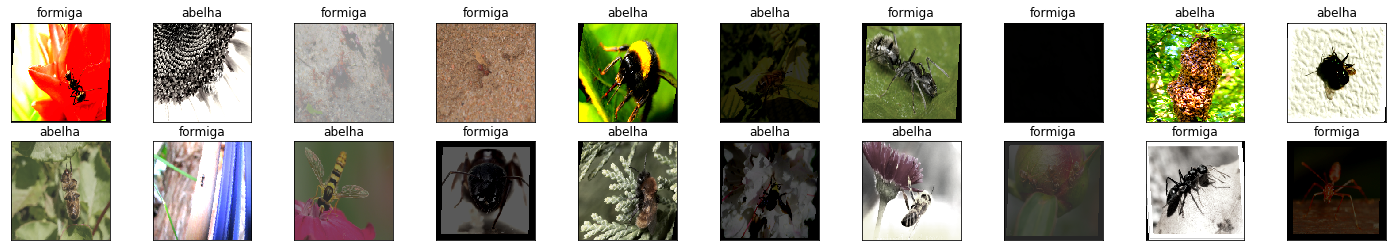

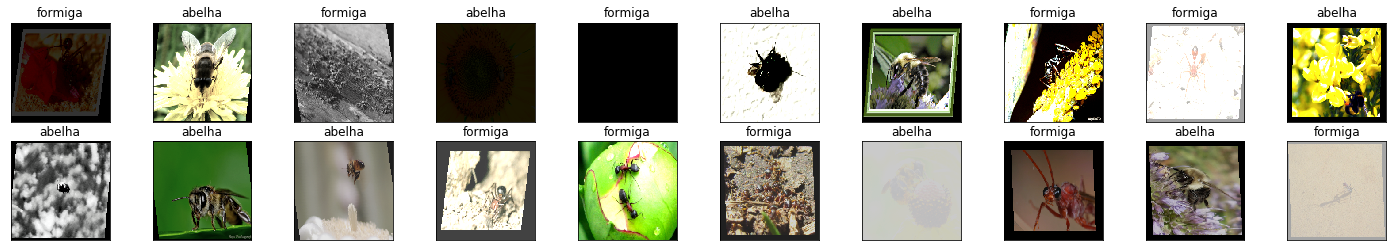

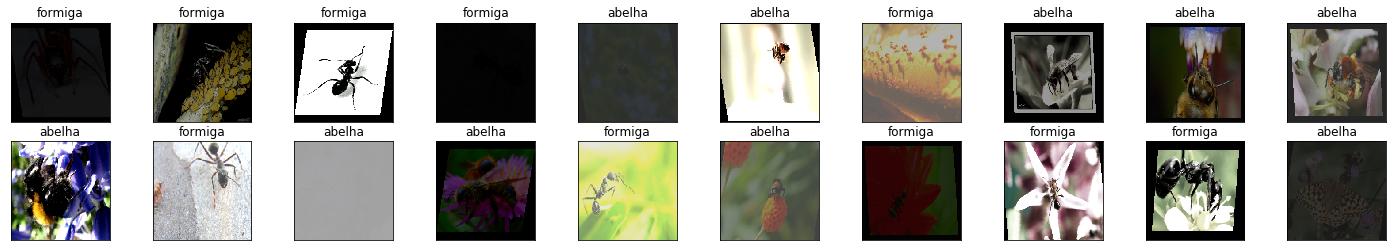

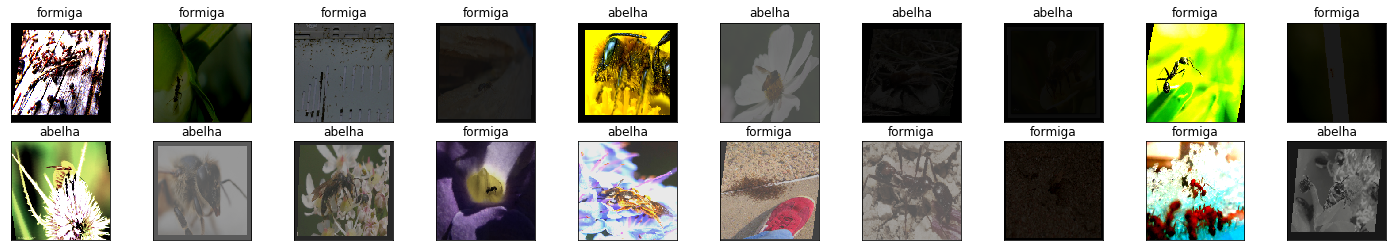

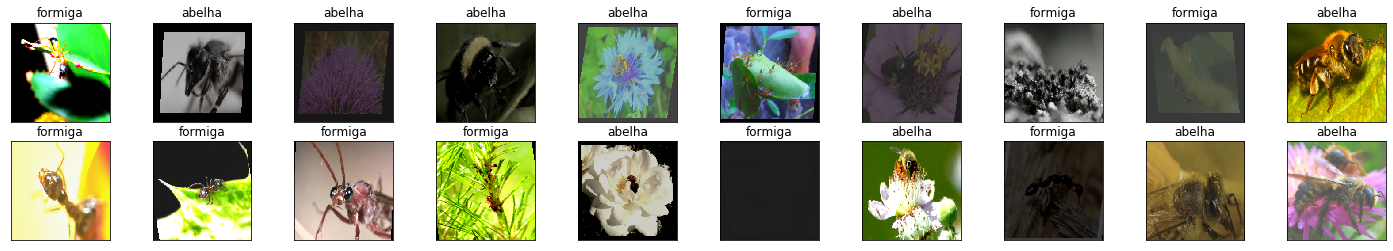

In [15]:
# Para o modelo AlexNet
# Função de custo CrossEntropy e Otimizador Adam
criterion = criterionCrossEntropy
optimizer = optimizerAdamAlexNet
epochs = 5

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelAlexNet, epochs)

####  Para testar o modelo AlexNet com Função de custo CrossEntropy e Otimizador SGD execute a celula abaixo

In [81]:
# Para o modelo AlexNet
# Função de custo CrossEntropy e Otimizador SGD
criterion = criterionNLLL
optimizer = optimizerSGDAlexNet
epochs = 10

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelAlexNet, epochs)

epoch : 1
training loss: -0.4576, acc 0.5984 
validation loss: -1.5805, validation acc 0.7582 
epoch : 2
training loss: -4.4152, acc 0.6393 
validation loss: -10.6777, validation acc 0.6732 
epoch : 3
training loss: -19.9901, acc 0.5123 
validation loss: -43.6931, validation acc 0.5490 
epoch : 4
training loss: -69.1810, acc 0.5041 
validation loss: -129.7856, validation acc 0.5425 
epoch : 5
training loss: -187.2489, acc 0.4959 
validation loss: -323.5573, validation acc 0.5425 
epoch : 6
training loss: -423.1937, acc 0.4959 
validation loss: -692.5827, validation acc 0.5425 
epoch : 7
training loss: -859.0101, acc 0.4959 
validation loss: -1320.5600, validation acc 0.5425 
epoch : 8
training loss: -1511.2806, acc 0.4959 
validation loss: -2290.0294, validation acc 0.5425 
epoch : 9
training loss: -2684.8587, acc 0.4959 
validation loss: -3723.0585, validation acc 0.5425 
epoch : 10
training loss: -4038.9029, acc 0.4959 
validation loss: -5676.1721, validation acc 0.5425 


####  Para testar o modelo AlexNet com Função de custo NLLL e Otimizador SGD execute a celula abaixo

In [85]:
# Para o modelo AlexNet
# Função de custo NLLL e Otimizador Adam
criterion = criterionCrossEntropy
optimizer = optimizerSGDAlexNet
epochs = 10

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelAlexNet, epochs)

epoch : 1
training loss: 1198.5599, acc 0.4877 
validation loss: 634.9528, validation acc 0.4575 
epoch : 2
training loss: 925.7609, acc 0.5205 
validation loss: 184.7941, validation acc 0.5425 
epoch : 3
training loss: 567.7679, acc 0.5287 
validation loss: 802.8160, validation acc 0.5425 
epoch : 4
training loss: 570.1260, acc 0.5123 
validation loss: 232.9087, validation acc 0.5425 
epoch : 5
training loss: 400.2725, acc 0.5451 
validation loss: 113.3197, validation acc 0.4575 
epoch : 6
training loss: 603.1219, acc 0.4385 
validation loss: 309.4704, validation acc 0.4575 
epoch : 7
training loss: 320.4783, acc 0.4959 
validation loss: 1307.1179, validation acc 0.5425 
epoch : 8
training loss: 428.1523, acc 0.4795 
validation loss: 286.6837, validation acc 0.5425 
epoch : 9
training loss: 249.9690, acc 0.5369 
validation loss: 205.0976, validation acc 0.4575 
epoch : 10
training loss: 285.7392, acc 0.4672 
validation loss: 1150.4700, validation acc 0.4575 


####  Para testar o modelo AlexNet com Função de custo NLLL e Otimizador SGD execute a celula abaixo

In [109]:
# Para o modelo AlexNet
# Função de custo NLLL e Otimizador SGD
criterion = criterionNLLL
optimizer = optimizerSGDAlexNet
epochs = 10

# Executa o treinamento do modelo
Treinamento(optimizer, criterion, modelAlexNet, epochs)

epoch : 1
training loss: -0.1916, acc 0.5861 
validation loss: -0.1987, validation acc 0.7190 
epoch : 2
training loss: -0.2372, acc 0.6557 
validation loss: -0.2351, validation acc 0.6928 
epoch : 3
training loss: -0.2754, acc 0.5984 
validation loss: -0.2779, validation acc 0.6797 
epoch : 4
training loss: -0.3258, acc 0.6721 
validation loss: -0.3194, validation acc 0.7255 
epoch : 5
training loss: -0.3530, acc 0.6107 
validation loss: -0.3634, validation acc 0.6993 
epoch : 6
training loss: -0.4210, acc 0.6148 
validation loss: -0.4020, validation acc 0.7124 
epoch : 7
training loss: -0.4592, acc 0.6721 
validation loss: -0.4515, validation acc 0.6732 
epoch : 8
training loss: -0.5144, acc 0.6475 
validation loss: -0.4983, validation acc 0.6993 
epoch : 9
training loss: -0.5642, acc 0.6762 
validation loss: -0.5675, validation acc 0.7320 
epoch : 10
training loss: -0.6411, acc 0.6762 
validation loss: -0.6244, validation acc 0.7124 


#### Grafico comparativo dos valores de custo do treinamento e validação 

Text(0.5, 1.0, 'Grafico comparativo dos valores de custo do treinamento e validação')

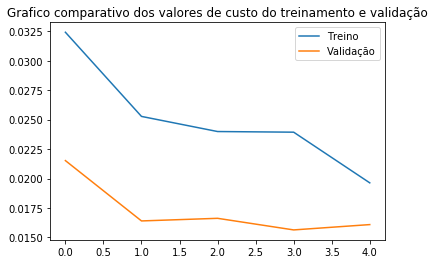

In [16]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend(['Treino','Validação'])
plt.title('Grafico comparativo dos valores de custo do treinamento e validação')

#### Grafico comparativo dos valores de acuracia do treinamento e validação 

Text(0.5, 1.0, 'Grafico comparativo dos valores de acurácia do treinamento e validação')

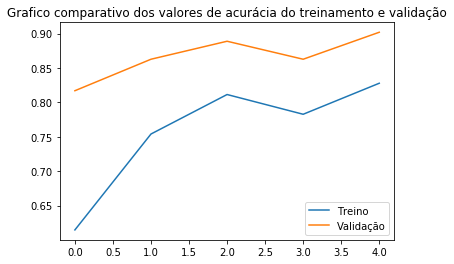

In [17]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend(['Treino','Validação'])
plt.title('Grafico comparativo dos valores de acurácia do treinamento e validação')

#### Na celula abaixo executo o teste do modelo com uma imagem qualquer, carregada da internet 

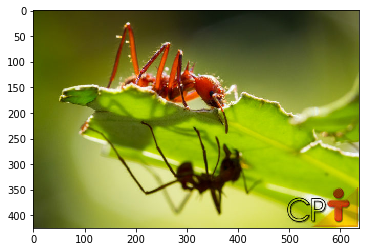

In [18]:
# Caso o pacote pillow não  esteja instalado execute o comendo abaixo:
# !pip3 install pillow==4.0.0
import PIL.ImageOps
import requests
from PIL import Image
from random import randint

url = ['https://www.odebateon.com.br/wp-content/uploads/2018/10/ant-debunking-the-ant-vs-grasshopper-myth-anthony-davis-celtics.jpg',
'https://www.coladaweb.com/wp-content/uploads/2018/08/20180808-formiga.jpg',
'https://aprenda.bio.br/wp-content/uploads/2019/02/curiosidades-sobre-as-formigas.jpg',
'https://www.biomax-mep.com.br/wp-content/uploads/2017/08/formigas.jpg',
'https://cptstatic.s3.amazonaws.com/imagens/enviadas/materias/materia10064/formigas-cortadeiras-artigos-cursos-cpt.jpg',
'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Meat_eater_ant_feeding_on_honey02.jpg/250px-Meat_eater_ant_feeding_on_honey02.jpg',
'https://www.sanitas.com.br/sites/default/files/2019-04/formigas-pragas-sanitas-desinsetizacao.jpg','https://i.ytimg.com/vi/F8s3SHJzsow/hqdefault.jpg',
'https://2.bp.blogspot.com/-oJLnPRAvHP8/WUlTKlMCkII/AAAAAAAAJKI/-Onm2qF_jc8y4Dm_PjspR64eMGe5Z0wDACEwYBhgL/s1600/texana18-L.jpg',
'https://paranaportal.uol.com.br/wp-content/uploads/2019/07/ss-1.png',
'http://novo.ddmat.com.br/images/13.jpg',
'https://dicas.boisaude.com.br/wp-content/uploads/2019/06/formiga-cortadeira.jpg',
'http://s2.glbimg.com/WTH1fVtmSesPT_XrjdktXvLSxh4=/780x440/e.glbimg.com/og/ed/f/original/2017/11/24/30797664452_e8203cd5b1_b.jpg',
'https://cdn1.campograndenews.com.br/uploads/tmp/images/5227553/640x480-eaa6a9fdc09e2a8732e1fe07ab336a9e.jpg',
'http://www.brotale.com.br/wp-content/uploads/2018/07/formiga-300x200.jpg',
'https://http2.mlstatic.com/isca-para-formigas-cortadeiras-1kg-D_NQ_NP_471705-MLB25065140508_092016-F.jpg',
'https://cptstatic.s3.amazonaws.com/imagens/enviadas/materias/materia10082/2formigas-cortadeiras-cursos-cpt.jpg',
'https://statig0.akamaized.net/bancodeimagens/ed/b5/a1/edb5a1h6xtv5iqoox55kpbn7t.jpg',
'https://3.bp.blogspot.com/-lxv29Mf6Gzw/TxhkWVaoE5I/AAAAAAAAB3c/cEFzCsQ85Yk/s1600/fomigas.jpg',
'https://gizmodo.uol.com.br/wp-content/blogs.dir/8/files/2017/04/formigas-soldados.jpg',
'https://www.hypeness.com.br/wp-content/uploads/2018/02/miga.jpg','https://blog.strider.ag/wp-content/uploads/2018/09/abelha-20130705-001.jpg',
'http://bemblogado.com.br/site/wp-content/uploads/2019/03/abelha.png',
'https://static.mundoeducacao.bol.uol.com.br/mundoeducacao/conteudo/polinizacao-por-abelha.jpg',
'https://ichef.bbci.co.uk/news/660/cpsprodpb/F26F/production/_105636026_gettyimages-1005384726.jpg',
'https://www.diariodocentrodomundo.com.br/wp-content/uploads/2019/01/abelhas.png',
'http://sustentahabilidade.com/wp-content/uploads/2017/09/Abelhas.jpg',
'http://www.abelhasjatai.com.br/wp-content/uploads/2017/02/abelha_polinizando-730x430.jpg',
'http://4.bp.blogspot.com/-MDRreL7Myq4/VVS2PjBe3II/AAAAAAAAOzY/bQPIwnxQEOg/s1600/ABELHA%2BPOLINIZANDO.jpg',
'https://static.mundoeducacao.bol.uol.com.br/mundoeducacao/conteudo/polinizacao-por-abelha.jpg',
'https://cdn-istoe-ssl.akamaized.net/wp-content/uploads/sites/14/2019/05/e8f4af6424800391795df49598ab5e9bc529e225.jpg',
'http://conexaoplaneta.com.br/wp-content/uploads/2018/05/amsterdam-registra-aumento-populacao-abelhas-conexao-planeta.jpg',
'https://cdn-istoe-ssl.akamaized.net/wp-content/uploads/sites/14/2019/05/e8f4af6424800391795df49598ab5e9bc529e225.jpg',
'https://www.redebrasilatual.com.br/wp-content/uploads/2019/05/Abelhas.jpg',
'https://www.dinheirovivo.pt/wp-content/uploads/2016/04/abelha-1060x594.jpg',
'http://jundiagora.com.br/wp-content/uploads/2018/04/abelha-com-polen.jpg',
'https://static.wixstatic.com/media/d40923_3938a9d15cca45d5b56554f82ff6c6df~mv2.jpg',
'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4KDvgA2yxulqrWIU3uM6iOYWtmkF_D4CoM3wOrhu0Yra8TBBX',
'https://img3.stockfresh.com/files/k/kidza/m/99/7772982_stock-photo-bee-collects-nectar-and-pollen.jpg',
'https://thumbs.dreamstime.com/b/bee-covered-pollen-honey-yellow-39168856.jpg',
'http://lamaisondelabeille.fr/wp-content/uploads/2014/09/bp17.jpg',
'http://diariodocomercio.com.br/wp-content/uploads/2019/02/abelhas.jpg']

a = url[randint(0,len(url))]
response = requests.get(a, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


#### Na celula abaixo é feito o tratamento da imagem carregada anteriorente para deixa-la pronta para ser submetida ao classificador

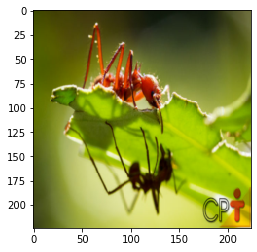

In [19]:
img = transform_validation(img) 
plt.imshow(im_convert(img))

#### Execute o código da celula abaixo para classificar com o modelo VGG a imagem tratada na celula anterior

In [37]:
image = img.to(device).unsqueeze(0)
output = modelVgg(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

abelha


#### Execute o código da celula abaixo para classificar com o modelo AlexNet a imagem tratada na celula anterior

In [38]:
image = img.to(device).unsqueeze(0)
output = modelAlexNet(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

formiga


#### Na celula abaixo é submetido um Batch de 20 imagens ao modelo VGG treinado aneriormente

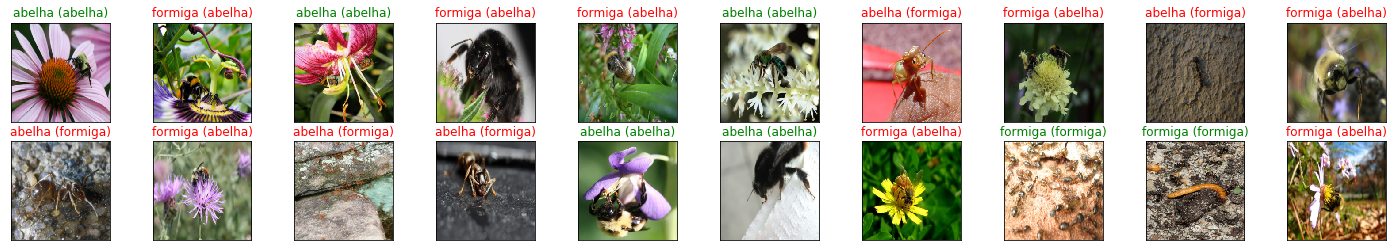

In [20]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = modelVgg(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

#### Na celula abaixo é submetido um Batch de 20 imagens ao modelo AlexNet treinado aneriormente

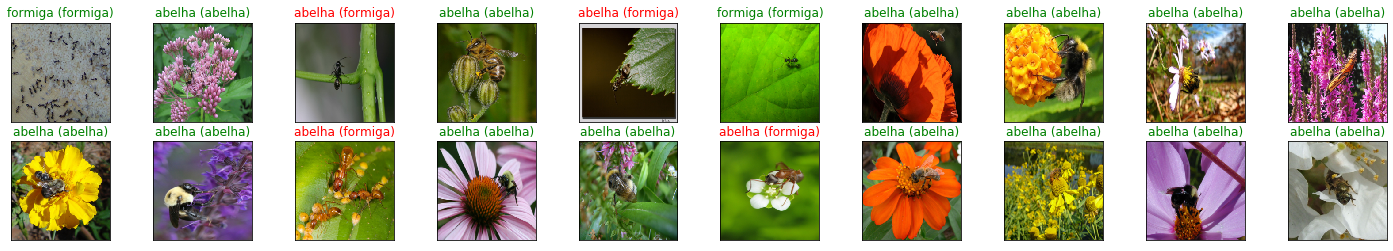

In [116]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = modelAlexNet(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))